<a href="https://colab.research.google.com/github/sekunder/NMA_Project/blob/master/Orientation_Selectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Data retrieval and loading and Matplotlib import
#get the data
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

#load it into a dict
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())
print(dat['sresp'].shape)
N_neurons = dat['sresp'].shape[0]

#import pyplot and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])
(23589, 4598)


dat has fields:
* dat['sresp']: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* dat['run']: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* dat['istim']: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* dat['stat']: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.
* dat['stat'][k]['med']: 1 by 2, the position of each neuron k in tissue, in pixels, at a resolution of ~2um/pix. 
* dat['u_spont']: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* dat['v_spont']: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* dat['u_spont'] @ dat['v_spont']: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.

In [3]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 

# Number of components to use
n_cmp = 20

Z = zscore(dat['sresp'], axis=1)
p = PCA(n_components = n_cmp)
p.fit_transform(Z.T)
X = p.components_@Z

After the above block runs, the variable `Z` has the z-scored firing rates, and `X` is the top `n_cmp` PCs of the z-scored firing rates.

In [6]:
# Using mutual information between stimulus and response as a proxy for "orientation selectivity"

MI_Stimulus = np.zeros(N_neurons)
MI_Running = np.zeros(N_neurons)
HRS = np.zeros(N_neurons)

favorite_neurons = [17, 6, 35, 8, 99]

# hist_bins = 20
R_bins = 10
S_bins = 10
P_S, S_bins = np.histogram(dat['istim'], density=True, bins=S_bins)
P_speed, speed_bins = np.histogram(dat['run'], density=True, bins=S_bins)
# print(P_S)
for neuron in range(N_neurons):
  P_R, R_bins = np.histogram(Z[neuron, :], density=True, bins=R_bins)
  
  P_RS, RS_R_bins, RS_S_bins = np.histogram2d(Z[neuron, :], dat['istim'],
                                              bins=[R_bins, S_bins], density=True)
  P_R_P_S = np.outer(P_R, P_S)
  summands_MI = P_RS * np.log2(P_RS / P_R_P_S, out=np.zeros_like(P_RS), where=P_R_P_S!=0)
  # MI_Stimulus[neuron] = np.sum(np.where(~np.isnan(summands_MI)))
  MI_Stimulus[neuron] = np.sum(summands_MI, where=~np.isnan(summands_MI))

  P_R_P_Sp = np.outer(P_R, P_speed)
  P_RSp, RSp_R_bins, RSp_Sp_bins = np.histogram2d(Z[neuron,:], dat['run'],
                                                  bins=[R_bins,S_bins], density=True)
  summands_MIsp = P_RSp * np.log2(P_RSp / P_R_P_Sp, out=np.zeros_like(P_RSp), where=P_R_P_Sp!=0)
  MI_Running[neuron] = np.sum(summands_MIsp, where=~np.isnan(summands_MIsp))

for neuron, mi, misp in zip(favorite_neurons, MI_Stimulus[favorite_neurons], MI_Running[favorite_neurons]):
  print("Neuron",neuron,"has mutual information",mi,"bits with the stimulus, and ",misp," bits with running speed")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


Neuron 17 has mutual information 0.018303594370329655 bits with the stimulus, and  0.019351684779194654  bits with running speed
Neuron 6 has mutual information 0.012141113418626911 bits with the stimulus, and  0.02492706177260516  bits with running speed
Neuron 35 has mutual information 0.007339556398061017 bits with the stimulus, and  0.020544524393780406  bits with running speed
Neuron 8 has mutual information 0.01965819174050596 bits with the stimulus, and  0.04612028892991697  bits with running speed
Neuron 99 has mutual information 0.07844269671605496 bits with the stimulus, and  0.02146034452286405  bits with running speed


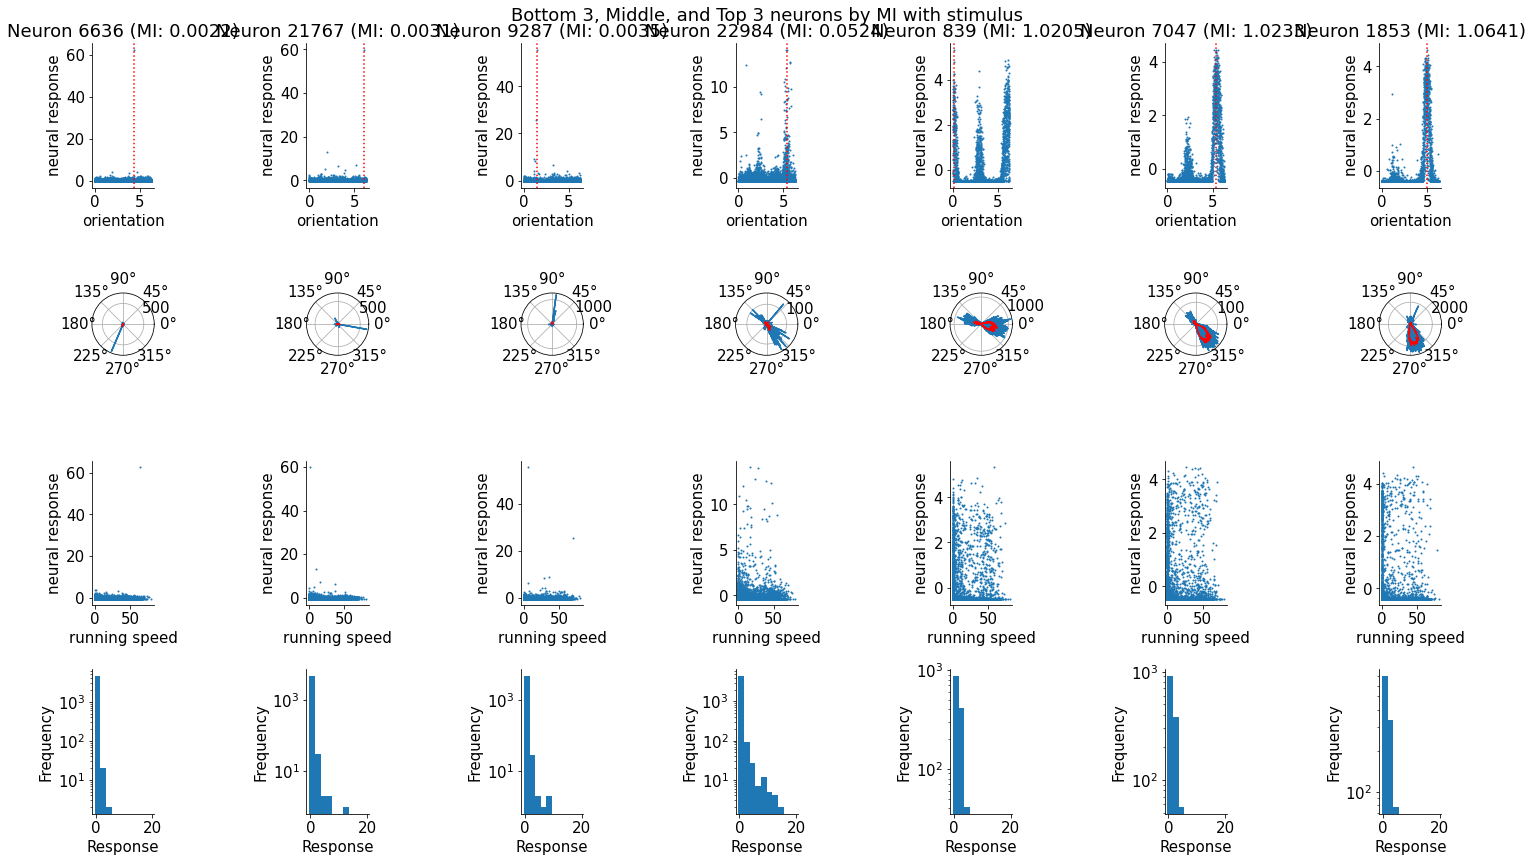

In [9]:
# Starting to play around with individual neuron tuning.
# Ideally, we can find some way to characterize neurons by how "selective" they are
# for orientation, since that's a simple thing to compare between stimuli.
from scipy.ndimage import gaussian_filter1d

fig_rows = 4

R = dat['sresp']
isort = np.argsort(dat['istim'])
R_sorted = R[:,isort]

MI_sort_idx = np.argsort(MI_Stimulus)


O = R @ dat['istim'] / R.sum(axis=1)

favorite_neurons = [17, 6, 35, 8, 99]
# favorite_neurons = [8, 99]
# favorite_neurons = np.random.choice(range(N_neurons), size=5)
# favorite_neurons = [838, 19431, 190, 6265, 16355]
favorite_neurons = [MI_sort_idx[0], MI_sort_idx[1], MI_sort_idx[2], MI_sort_idx[len(MI_sort_idx)//2], MI_sort_idx[-3], MI_sort_idx[-2], MI_sort_idx[-1]]
plt.figure(figsize=(3 * len(favorite_neurons), fig_rows * 3))
for i, n in enumerate(favorite_neurons):
  row = 0
  ax = plt.subplot(fig_rows,len(favorite_neurons),i+1 + row * len(favorite_neurons))
  plt.scatter(dat['istim'], Z[n,:], s=1)
  # plt.axvline(O[n], c='red', linestyle=':')
  plt.axvline(dat['istim'][np.argmax(Z[n, :])], c='red', linestyle=':')
  ax.set(xlabel = 'orientation', ylabel = 'neural response', title='Neuron %d (MI: %.4f)'%(n,MI_Stimulus[n]))

  row += 1
  ax = plt.subplot(fig_rows,len(favorite_neurons), i+1 + len(favorite_neurons), polar=True)
  plt.polar(sorted(dat['istim']), R_sorted[n,:])
  filtered = gaussian_filter1d(R_sorted[n,:], 5)
  plt.polar(sorted(dat['istim']), filtered, c="red")
  # ax.set(xlabel="orientation", ylabel="response")

  # row += 1
  # ax = plt.subplot(fig_rows, len(favorite_neurons), i + 1 + row * len(favorite_neurons))
  # P_RS, RS_R_bins, RS_S_bins = np.histogram2d(Z[neuron, :], dat['istim'],
  #                                             bins=[R_bins, S_bins], density=True)
  # plt.imshow(P_RS)

  row += 1
  ax = plt.subplot(fig_rows, len(favorite_neurons), i+1 + row*len(favorite_neurons))
  plt.scatter(dat['run'], Z[n,:], s=1)
  ax.set(xlabel = 'running speed', ylabel='neural response')

  row += 1
  ax = plt.subplot(fig_rows, len(favorite_neurons), i + 1 + row*len(favorite_neurons))
  plt.hist(Z[n,:], bins=R_bins)
  ax.set(xlabel="Response", ylabel="Frequency", yscale="log")

  plt.suptitle('Bottom 3, Middle, and Top 3 neurons by MI with stimulus', y=1)

### Looking at a random sampling of neurons

The below cell will plot a figure of `n_rows * n_cols` neurons. Each neuron is plotted as its response vs. stimulus orientation. The title gives the rank (from low to high mutual information), the neuron ID, and the mutual information between that neuron's response and the stimulus orientation (in bits). Neurons are plotted in descending order of mutual information, so we should expect to see each progressively worse-defined "tuning curves" near the end. Note that if a neuron is highly tuned to multiple angles (i.e. it has a multimodal response curve), it might still have high mutual information, so we'll need another way to compute orientation selectivity if we care about that.

In [ ]:
# let's look at a random sampling of neurons

n_rows = 4
n_cols = 5

indices = sorted(np.random.choice(range(N_neurons), size=n_rows * n_cols), reverse=True)
# indices = range(N_neurons-20, N_neurons)
random_neurons = np.argsort(MI_Stimulus)[indices]

plt.figure(figsize=(3 * n_cols, 3 * n_rows))
for i, n in enumerate(random_neurons):
  ax = plt.subplot(n_rows, n_cols, i+1)
  plt.scatter(dat['istim'], Z[n,:], s=1)
  plt.axvline(dat['istim'][np.argmax(Z[n, :])], c='red', linestyle=':')
  ax.set(xlabel = 'orientation', ylabel = 'response', title='(#%d) Neuron %d\n(MI: %.4f)'%(indices[i],n,MI_Stimulus[n]))

[Text(0, 0.5, 'MI with speed'),
 Text(0.5, 0, 'MI with stimulus'),
 Text(0.5, 1.0, 'Speed vs. Stimulus')]

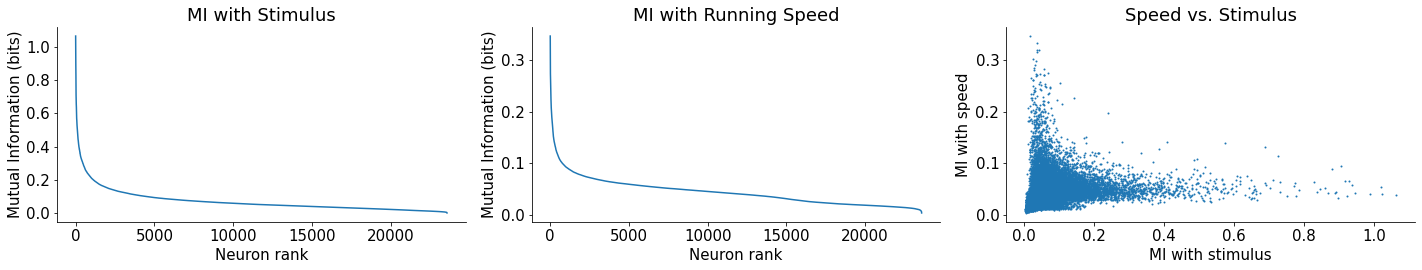

In [16]:
ax = plt.subplot(1,3,1)
plt.plot(range(len(MI_Stimulus)), sorted(MI_Stimulus, reverse=True))
ax.set(xlabel="Neuron rank", ylabel="Mutual Information (bits)", title="MI with Stimulus")

ax = plt.subplot(1,3,2)
plt.plot(range(len(MI_Running)), sorted(MI_Running, reverse=True))
ax.set(xlabel="Neuron rank", ylabel="Mutual Information (bits)", title="MI with Running Speed")

ax = plt.subplot(1,3,3)
plt.scatter(MI_Stimulus, MI_Running, s=1)
ax.set(xlabel='MI with stimulus', ylabel='MI with speed', title="Speed vs. Stimulus")

In [ ]:
 
print(O[favorite_neurons])
print("Max stimulus:",max(dat['istim']),"Min Stimulus:",min(dat['istim']))


[3.08313406 2.88758685 3.29010348 3.14439016 3.08817968]
Max stimulus: 6.282404857491223 Min Stimulus: 0.0006091591363192009


## Attempting dPCA 

Below, we try to use dPCA

In [ ]:
#@title Load dPCA code
!git clone https://github.com/machenslab/dPCA.git
import os, sys
sys.path.append("/content/dPCA/python")
from dPCA import dPCA

Cloning into 'dPCA'...
remote: Enumerating objects: 264, done.
remote: Total 264 (delta 0), reused 0 (delta 0), pack-reused 264
Receiving objects: 100% (264/264), 1.28 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (127/127), done.


/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/dPCA/python/dPCA/nan_shuffle.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [ ]:
# Trying to figure out how to organize the data so dPCA can be used
idx = np.argsort(dat['istim'])
sorted_angles = np.sort(dat['istim'])
indices = np.arange(len(sorted_angles))
# R_binned = np.zeros()
for i in range(20):
  idx_range = indices[((i * np.pi / 10) < sorted_angles) & (sorted_angles < (i+1) * (np.pi / 10))]
  print(min(idx_range), max(idx_range), '# samples: ', max(idx_range) - min(idx_range))
  

0 247 # samples:  247
248 455 # samples:  207
456 682 # samples:  226
683 919 # samples:  236
920 1157 # samples:  237
1158 1410 # samples:  252
1411 1638 # samples:  227
1639 1859 # samples:  220
1860 2075 # samples:  215
2076 2295 # samples:  219
2296 2518 # samples:  222
2519 2770 # samples:  251
2771 3001 # samples:  230
3002 3237 # samples:  235
3238 3455 # samples:  217
3456 3688 # samples:  232
3689 3912 # samples:  223
3913 4155 # samples:  242
4156 4381 # samples:  225
4382 4597 # samples:  215
